---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 5_2

---

Please write your full name here
- **Name** : "Mahmoud Hamdy Mahmoud"

## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits.
Within this notebook you will find instructions in each section for how to complete the assignment.

Pay close attention to the instructions. Feel free to add extra cells into the notebook as required.

### Let's get started!

We'll start by running some imports, and loading the dataset. You are free to make further imports throughout the notebook as you wish.

In [269]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
import matplotlib.pyplot as plt


For this assignmnet, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`.

- If using Colab: You should store these files in Drive.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
### Using Colab only
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-12-11 18:21:10--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  5.49MB/s    in 31s     

2023-12-11 18:21:42 (5.59 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2023-12-11 18:21:42--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  3.64MB/s    in 31s     

2023-12-11 18:22:13 (1.97 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
!mv train_32x32.mat /content/gdrive/MyDrive
!mv test_32x32.mat /content/gdrive/MyDrive

In [270]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure. Make sure that the images are displayed in grayscale!!

In [271]:
y_train = train["y"]
y_test = test["y"]
X_train = train["X"]
X_test = test["X"]

In [272]:
X_train = tf.transpose(X_train, perm=[3, 0, 1, 2])
X_test = tf.transpose(X_test, perm=[3, 0, 1, 2])

In [273]:
def generateRnadomImgs(num, imgs, lbls, map=None):
    dataset = tf.data.Dataset.from_tensor_slices((imgs, lbls))
    dataset = dataset.shuffle(buffer_size=len(lbls))
    sample_size = num
    sample = dataset.take(sample_size)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
    for i, (image, label) in enumerate(sample):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(image.numpy(), cmap= map)
        axes[row, col].set_title(f"Label: {label.numpy()}")
        axes[row, col].axis("off")
    plt.show()

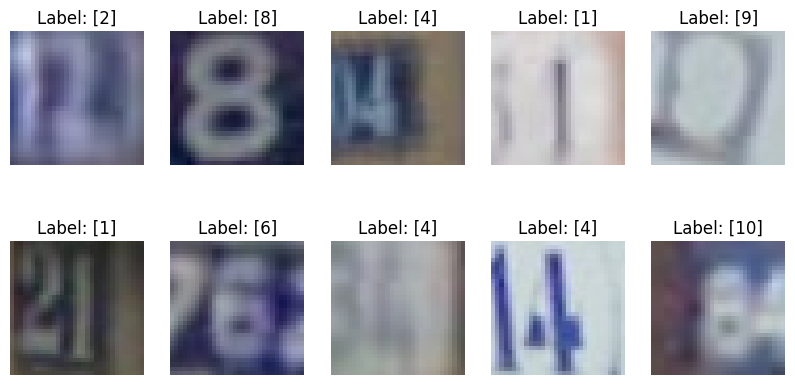

In [274]:
generateRnadomImgs(10, X_train, y_train)

In [275]:
X_train_gray = tf.math.reduce_mean(X_train, axis=3)
X_test_gray = tf.math.reduce_mean(X_test, axis=3)

In [276]:
X_train_gray /= 255
X_test_gray /= 255

In [289]:
y_train -= 1
y_test -= 1

<Figure size 500x200 with 0 Axes>

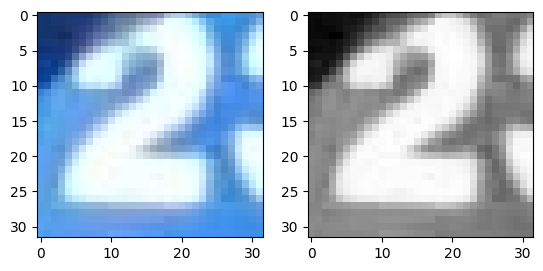

In [277]:
plt.figure(figsize=(5, 2))
fig, axes = plt.subplots(1,2)
axes[0].imshow((X_train[2]))
axes[1].imshow((X_train_gray[2]), cmap='gray')
# plt.axis('off')
plt.show()

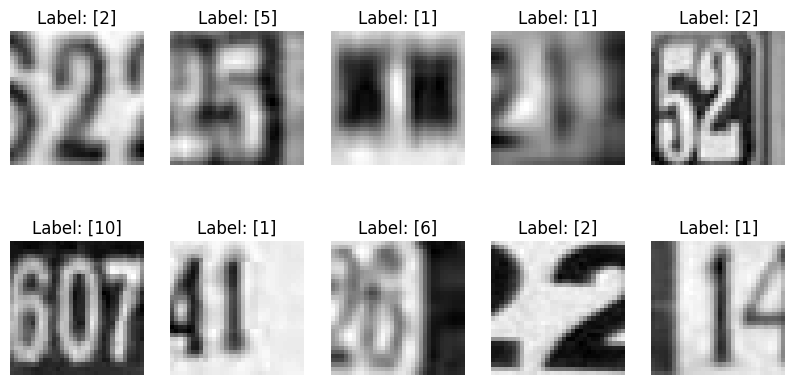

In [278]:
generateRnadomImgs(10, X_train_gray, y_train, "gray")

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least one **callback** during training, like a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
X_train_gray[0].shape

TensorShape([32, 32])

In [285]:
def build_MLP():
  model = tf.keras.Sequential([
    Flatten(input_shape=(32,32,1)),
    # Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
  ])
  return model

In [286]:
model = build_MLP()
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_31 (Flatten)        (None, 1024)              0         
                                                                 
 dense_100 (Dense)           (None, 128)               131200    
                                                                 
 dense_101 (Dense)           (None, 32)                4128      
                                                                 
 dense_102 (Dense)           (None, 10)                330       
                                                                 
Total params: 135658 (529.91 KB)
Trainable params: 135658 (529.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [304]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0),
              metrics=['accuracy'])

In [283]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='MLPmodel.h5',
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                            save_freq='epoch',
                                                         save_best_only=True,
                                                         verbose=1)

In [305]:
history = model.fit(tf.convert_to_tensor(X_train_gray, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.int32),
                    batch_size = 64, epochs=20, validation_split=0.2, callbacks=[checkpoint_callback])

Epoch 1/20
915/916 [============================>.] - ETA: 0s - loss: 0.8464 - accuracy: 0.7429
Epoch 1: val_accuracy improved from 0.73321 to 0.74120, saving model to MLPmodel.h5
916/916 [==============================] - 5s 4ms/step - loss: 0.8461 - accuracy: 0.7430 - val_loss: 0.8713 - val_accuracy: 0.7412
Epoch 2/20
915/916 [============================>.] - ETA: 0s - loss: 0.8306 - accuracy: 0.7499
Epoch 2: val_accuracy did not improve from 0.74120
916/916 [==============================] - 4s 4ms/step - loss: 0.8307 - accuracy: 0.7499 - val_loss: 0.8837 - val_accuracy: 0.7361
Epoch 3/20
911/916 [============================>.] - ETA: 0s - loss: 0.8328 - accuracy: 0.7500
Epoch 3: val_accuracy did not improve from 0.74120
916/916 [==============================] - 5s 6ms/step - loss: 0.8326 - accuracy: 0.7500 - val_loss: 0.9229 - val_accuracy: 0.7200
Epoch 4/20
915/916 [============================>.] - ETA: 0s - loss: 0.8217 - accuracy: 0.7529
Epoch 4: val_accuracy improved from 0

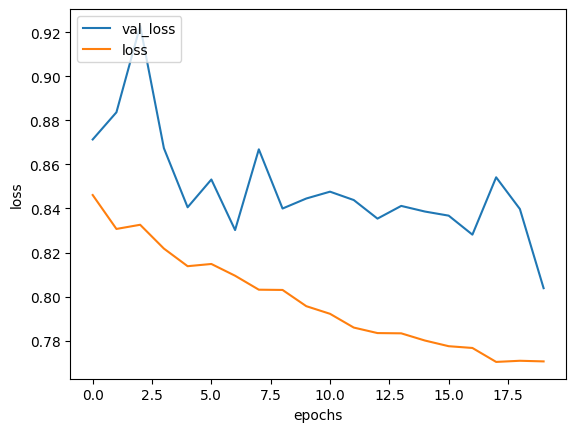

In [306]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["val_loss", "loss"], loc="upper left")
plt.show()

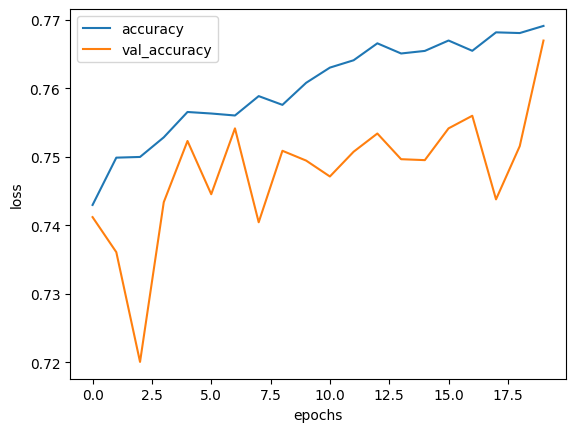

In [307]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [308]:
MLPTestLoss, MLPTestAcc = model.evaluate(X_test_gray, y_test)
print(f"MLP Testing Accuracy is: {MLPTestAcc}")
print(f"MLP Testing loss is: {MLPTestLoss}")

814/814 [==============================] - 3s 3ms/step - loss: 0.8940 - accuracy: 0.7460
MLP Testing Accuracy is: 0.74604332447052
MLP Testing loss is: 0.8940309882164001


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model **must** use fewer trainable parameters than your MLP model.
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least one callback during training, like a ModelCheckpoint callback.
* **You should aim to beat the MLP model performance with fewer parameters!**
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [291]:
def build_CNN():
  model = tf.keras.Sequential([
    Conv2D(16, kernel_size=(3,3), activation="relu", input_shape=(32,32, 1)),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(16, kernel_size=(3,3), activation = "relu"),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(.5),
    Dense(63, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
  ])
  return model

In [292]:
CnnModel = build_CNN()

In [293]:
CnnModel.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 16)        160       
                                                                 
 batch_normalization_15 (Ba  (None, 30, 30, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 15, 15, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 16)        2320      
                                                                 
 batch_normalization_16 (Ba  (None, 13, 13, 16)        64        
 tchNormalization)                                               
                                                     

In [313]:
CnnModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [312]:
checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath='model.h6',
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                            save_freq='epoch',
                                                         save_best_only=True,
                                                         verbose=1)

In [314]:
history = CnnModel.fit(X_train_gray,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        callbacks=[checkpoint_callback1],
                        validation_data=(X_test_gray, y_test))

Epoch 1/10
1144/1145 [============================>.] - ETA: 0s - loss: 0.7098 - accuracy: 0.7804
Epoch 1: val_accuracy improved from -inf to 0.85817, saving model to model.h6
1145/1145 [==============================] - 8s 6ms/step - loss: 0.7099 - accuracy: 0.7804 - val_loss: 0.4871 - val_accuracy: 0.8582
Epoch 2/10
1144/1145 [============================>.] - ETA: 0s - loss: 0.7016 - accuracy: 0.7820
Epoch 2: val_accuracy did not improve from 0.85817
1145/1145 [==============================] - 10s 8ms/step - loss: 0.7015 - accuracy: 0.7820 - val_loss: 0.4997 - val_accuracy: 0.8581
Epoch 3/10
1138/1145 [============================>.] - ETA: 0s - loss: 0.7004 - accuracy: 0.7836
Epoch 3: val_accuracy did not improve from 0.85817
1145/1145 [==============================] - 9s 8ms/step - loss: 0.7011 - accuracy: 0.7834 - val_loss: 0.5010 - val_accuracy: 0.8572
Epoch 4/10
1144/1145 [============================>.] - ETA: 0s - loss: 0.7009 - accuracy: 0.7828
Epoch 4: val_accuracy did no

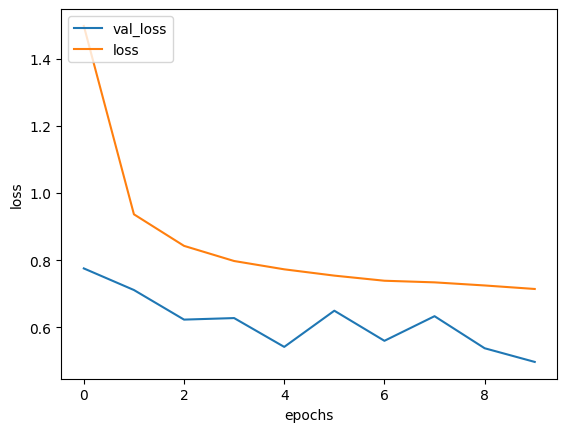

In [297]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["val_loss", "loss"], loc="upper left")
plt.show()

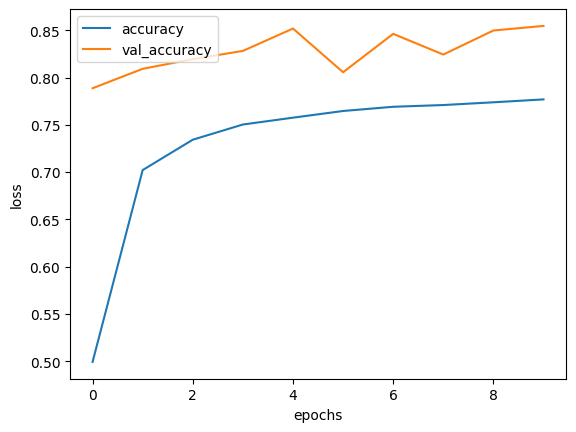

In [298]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [302]:
CNNTestLoss, CNNTestAcc = CnnModel.evaluate(X_test_gray, y_test)
print(f"Testing Accuracy is: {CNNTestAcc}")
print(f"Testing loss is: {CNNTestLoss}")

814/814 [==============================] - 4s 4ms/step - loss: 0.4970 - accuracy: 0.8546
Testing Accuracy is: 0.8546404242515564
Testing loss is: 0.4969698190689087


## 4. Get model predictions
* Load the **best weights** for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [323]:
y_train += 1
y_test += 1

In [318]:
from tensorflow.keras.models import load_model

CnnModel2 = build_CNN()
CnnModel2.load_weights("model.h6")

MLPModel2 = build_MLP()
MLPModel2.load_weights("MLPmodel.h5")

In [335]:
import random
random_numbers = (random.sample(range(0, y_test.shape[0] + 1), 5))

In [357]:
random_numbers = sorted(random_numbers)
imgs = np.array([X_test_gray[idx] for idx in random_numbers])

In [358]:
imgs.shape

(5, 32, 32)

In [361]:
MLPPred = MLPModel2.predict(imgs)
CNNPred = CnnModel2.predict(imgs)

1/1 [==============================] - 1s 515ms/step


<ipython-input-410-e7a9c72a175d>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, i * 3 + 1)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


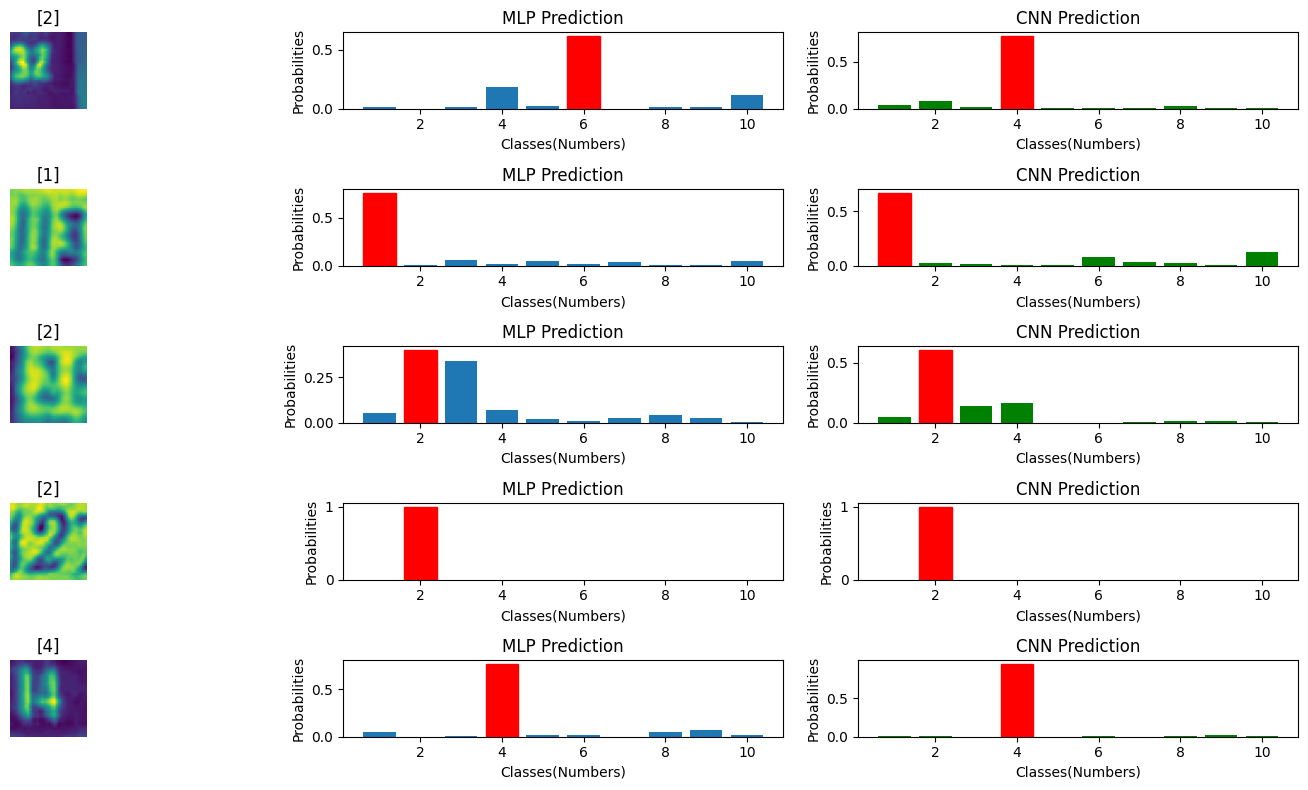

In [410]:
import numpy as np
fig, axes = plt.subplots(figsize=(15, 8))
for i in range(5):
  plt.subplot(5, 3, i * 3 + 1)
  plt.imshow(X_test_gray[random_numbers[i]])
  plt.title(y_test[random_numbers[i]])
  plt.axis("off")

#/////////////MLP\\\\\\\\\\\\\\
  plt.subplot(5, 3, i * 3 + 2)
  MlPb = plt.bar(range(1,11), MLPPred[i])
  plt.title("MLP Prediction")
  plt.ylabel("Probabilities")
  plt.xlabel("Classes(Numbers)")
  MlPb[np.argmax(MLPPred[i])].set_color("red")

#//////////////CNN\\\\\\\\\\\\\\
  plt.subplot(5, 3, i * 3 + 3)
  Cnnb = plt.bar(range(1,11), CNNPred[i], color="green")
  plt.title("CNN Prediction")
  plt.ylabel("Probabilities")
  plt.xlabel("Classes(Numbers)")
  Cnnb[np.argmax(CNNPred[i])].set_color("red")
plt.tight_layout()
plt.show()